In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import normalize
#%matplotlib inline
#%matplotlib widget


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/My Drive/Google Colab/Part II/

/content/drive/My Drive/Google Colab/Part II


In [4]:
# Loading the Datasets and class
X_dataset = pd.read_csv('GLVQData/train_data.csv', header=None).values
Y_dataset = pd.read_csv('GLVQData/train_target.csv', squeeze=True, header=None).values
X_test = pd.read_csv('GLVQData/test_data.csv').values

# Changing the names to numbers
Y_dataset, Original = pd.factorize(Y_dataset)

# Standardizing the data
X_dataset -= X_dataset.mean(0)
X_dataset = X_dataset / X_dataset.std(0)

X_test -= X_test.mean(0)
X_test = X_test / X_test.std(0)

# Normalizing the data
# X_dataset = normalize(X_dataset)
# X_test = normalize(X_test)

In [5]:
def pairwise_distance(A, B):
    difference = A[None, :] - B[:, None]
    square = difference * difference
    squared_sum = square.sum(axis=-1)
    distance = np.sqrt(squared_sum)

    return distance

In [6]:
# Training Loop

def GLVQ(X_dataset, Y_dataset, protos, protos_class, epoch, lt, lr):
    for _ in range(epoch):
        epoch_index = rng.choice(len(X_dataset))
        datapoint = X_dataset[epoch_index] # random datapoint
        datapoint_class = Y_dataset[epoch_index] # class of the datapoint
        distances = pairwise_distance(protos, datapoint[None,:])[0] # distance between all protoypes and random chosen datapoint
        # Initializing empty list and empty array
        d_plus = []
        d_plus_class = []
        d_minus = []
        d_minus_class = []
        matching_protos = np.array([])
        nonmatching_protos = np.array([])

        for i in range(len(protos_class)):
            # Datapoint and Prototypes with same class
            if datapoint_class == protos_class[i]: 
                d_plus.append(distances[i])
                d_plus_class.append(protos_class[i])
                if matching_protos.size > 0:
                    new_proto = np.expand_dims(protos[i], axis= 0)
                else:
                    new_proto = protos[i]
                matching_protos = np.append(matching_protos, new_proto, axis= 0)
                if matching_protos.size < 4:
                    matching_protos = np.expand_dims(matching_protos, axis= 0)
            # Datapoint and prototypes of different class
            else:
                d_minus.append(distances[i])
                d_minus_class.append(protos_class[i])
                if nonmatching_protos.size > 0:
                    new_proto = np.expand_dims(protos[i], axis= 0)
                else:
                    new_proto = protos[i]
                nonmatching_protos = np.append(nonmatching_protos, new_proto, axis= 0)
                if nonmatching_protos.size < 4:
                    nonmatching_protos = np.expand_dims(nonmatching_protos, axis= 0)

        d_plus = np.array(d_plus)
        d_plus_class = np.array(d_plus_class)
        d_minus = np.array(d_minus)
        d_minus_class = np.array(d_minus_class)
        d_plus_winner = d_plus.argmin() # index of minimum distance of the datapoint with the matching prototype
        w_plus = matching_protos[d_plus_winner] # closest matching prototype
        d_minus_winner = d_minus.argmin() # index of minimum distance of the datapoint with the nonmatching prototype
        w_minus = nonmatching_protos[d_minus_winner] # closest nonmatching prototype

        classifier_function = (d_plus[d_plus_winner] - d_minus[d_minus_winner]) / (d_plus[d_plus_winner] + d_minus[d_minus_winner])
        
        f = 1/(1 + np.exp(-lt*classifier_function))
        # Update rules
        w_plus +=  lr * (f*(1 - f)) * (d_minus[d_minus_winner]/ np.square(d_plus[d_plus_winner] + d_minus[d_minus_winner])) * (datapoint - w_plus)
        w_minus -= lr * (f*(1 - f)) * (d_plus[d_plus_winner]/ np.square(d_plus[d_plus_winner] + d_minus[d_minus_winner])) * (datapoint - w_minus)

        matching_protos[d_plus_winner] = w_plus
        nonmatching_protos[d_minus_winner] = w_minus
        protos = np.append(matching_protos, nonmatching_protos, axis= 0)
        protos_class = d_plus_class.tolist() + d_minus_class.tolist()

    return protos, protos_class
        

In [7]:
# Using idea from GridSearhCV to get the best epoch, lt and lr (More the number of parameters more time it will take for one whole loop to run)
for _ in range(10):
    param_grid = {'epoch': [900, 1000, 1100, 1200],
                'lt': [3, 4, 5],
                'lr': [0.2, 0.3, 0.4, 0.5],
                # 'lr' : [0.01, 0.03, 0.05, 0.07]
                # 'ppc': [2,3,4]
                }
    best_params = {'epoch': None, 'lt':None, 'lr':None, 'ppc':None}
    best_score = 0
    kf = KFold(n_splits=10)
    scores = []
    for train_index, test_index in kf.split(X_dataset):
        X_train, X_test = X_dataset[train_index], X_dataset[test_index]
        Y_train, Y_test = Y_dataset[train_index], Y_dataset[test_index]
        for epoch in param_grid['epoch']:
            for lt in param_grid['lt']:
                for lr in param_grid['lr']:
                    # for prototype_per_class in param_grid['ppc']:
                    prototype_per_class = 2
                    num_classes = len(np.unique(Y_dataset))
                    rng = np.random.default_rng()
                    protos = rng.random(size=(num_classes*prototype_per_class,X_train.shape[-1]))
                    protos = np.asarray(protos)
                    protos_class = list(np.unique(Y_dataset))*prototype_per_class

                    protos, protos_class = GLVQ(X_dataset=X_dataset, Y_dataset=Y_dataset, protos= protos, protos_class= protos_class, epoch= epoch, lt= lt, lr= lr)    
                    
                    prediction = []
                    for i in range(len(X_test)):
                        distances = pairwise_distance(protos, X_test[i][None,:])[0]
                        prediction.append(protos_class[np.argmin(distances)])
                    score = accuracy_score(Y_test, prediction)
                    if score > best_score:
                        best_score = score
                        best_params['epoch'] = epoch
                        best_params['lt'] = lt
                        best_params['lr'] = lr
                        best_params['ppc'] = prototype_per_class

    print("Best Parameters: ", best_params)
    print("Best Score: ", best_score)

KeyboardInterrupt: ignored

In [8]:
# Cross-Validation using KFold to check the accuracy score.

for _ in range(10):
    kf = KFold(n_splits=6)
    scores = []
    for train_index, test_index in kf.split(X_dataset):
        X_train, X_test = X_dataset[train_index], X_dataset[test_index]
        Y_train, Y_test = Y_dataset[train_index], Y_dataset[test_index]
        # Training Loop
        epoch = 1000
        lt = 4 # Learning Time
        lr = 0.5 # Learning Rate
        prototype_per_class = 2
        num_classes = len(np.unique(Y_dataset))
        rng = np.random.default_rng()
        protos = rng.random(size=(num_classes*prototype_per_class,X_dataset.shape[-1]))
        protos = np.asarray(protos)
        protos_class = list(np.unique(Y_dataset))*prototype_per_class

        protos, protos_class = GLVQ(X_dataset=X_dataset, Y_dataset=Y_dataset, protos= protos, protos_class= protos_class, epoch= epoch, lt= lt, lr= lr)

            
        prediction = []
        for i in range(len(X_test)):
            # print(protos, X_test[i])
            distances = pairwise_distance(protos, X_test[i][None,:])[0]
            prediction.append(protos_class[np.argmin(distances)])
        score = accuracy_score(Y_test, prediction)
        scores.append(score)

    print("Accuracy: %0.2f (+/- %0.2f)" % (np.mean(scores), np.std(scores) * 2))
    # print(scores)


Accuracy: 0.77 (+/- 0.19)
Accuracy: 0.75 (+/- 0.03)
Accuracy: 0.74 (+/- 0.09)
Accuracy: 0.76 (+/- 0.17)
Accuracy: 0.77 (+/- 0.16)
Accuracy: 0.79 (+/- 0.12)
Accuracy: 0.78 (+/- 0.06)
Accuracy: 0.74 (+/- 0.12)
Accuracy: 0.77 (+/- 0.16)
Accuracy: 0.77 (+/- 0.09)


In [9]:
# Initialize Prototypes
prototype_per_class = 2
num_classes = len(np.unique(Y_dataset))
rng = np.random.default_rng()
protos = rng.random(size=(num_classes*prototype_per_class,X_dataset.shape[-1]))
protos = np.asarray(protos)

protos_class = list(np.unique(Y_dataset))*prototype_per_class

# Methods tried - 1. rng.uniform
# 2. rng.random
# 3. random datapoints from the dataset
# 4. Hybrid initialization

In [10]:
# Code for 4.Hybrid initialization
# num_classes = len(np.unique(Y_dataset))
# rng = np.random.default_rng()
# # random_indices = rng.choice(len(X_dataset), size=num_classes, replace=False) # also tried with random datapoint instead of just a random point.
# random_prototypes = rng.random(size=(num_classes,X_dataset.shape[-1]))
# # random_prototypes = X_dataset[random_indices]

# # Use clustering to find additional prototypes
# kmeans = KMeans(n_clusters=num_classes, random_state=0)
# kmeans.fit(X_dataset)
# cluster_prototypes = kmeans.cluster_centers_
# # protos = kmeans.cluster_centers_
# # Combine the randomly selected and clustered prototypes
# protos = np.concatenate((random_prototypes, cluster_prototypes))
# protos_class = list(np.unique(Y_dataset))*2

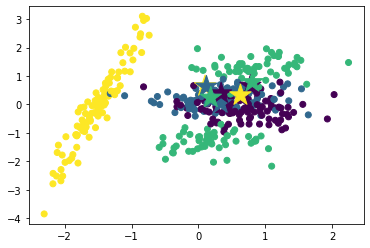

In [11]:
# Visualizing the datapoints in 2D for better Visualizing

X_datasetnew = X_dataset[:, (0,2)]
protosnew = protos[:, (0,2)]
plt.figure()
plt.scatter(*X_datasetnew.T, c=Y_dataset)
plt.scatter(*protosnew.T, c=protos_class, s=500, marker='*')
plt.show()

In [12]:
epoch =1100
lt = 4 # learning time
lr = 0.4 # learning rate

protos, protos_class = GLVQ(X_dataset=X_dataset, Y_dataset=Y_dataset, protos= protos, protos_class= protos_class, epoch= epoch, lt= lt, lr= lr)

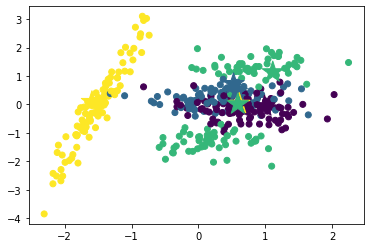

In [13]:
# Visualizing the datapoints and the prototypes in 2D
X_datasetnew1 = X_dataset[:, (0,2)]
protosnew1 = protos[:, (0,2)]
plt.figure()
plt.scatter(*X_datasetnew1.T, c=Y_dataset)
plt.scatter(*protosnew1.T, c=protos_class, s=500, marker='*')
plt.show()

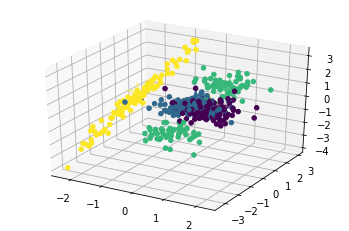

In [14]:
# 3D Visualizing the Datapoints and prototypes 
z, x, y = X_dataset[:, 2], X_dataset[:, 0], X_dataset[:, 1]
Z, X, Y = protos[:, 2], protos[:, 0], protos[:, 1]
fig = plt.figure()
ax = fig.add_subplot(111, projection= '3d')
ax.scatter(x,y,z, c=Y_dataset, alpha= 1)
ax.scatter(X,Y,Z, c=protos_class, s=500, marker= '*')
plt.show()


In [15]:
# Predicting class for the test dataset
predictions = []
for i in range(len(X_test)):
    distances_p = pairwise_distance(X_test[i], protos)
    predictions.append(protos_class[np.argmin(distances_p)])

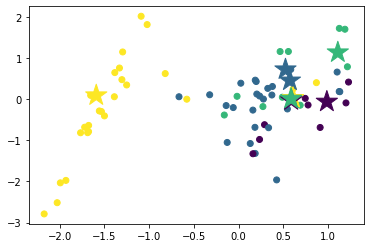

In [16]:
# Visualizing the predicted class and the test dataset with the prototypes
X_datasetnew1 = X_test[:, (0,2)]
protosnew2 = protos[:, (0,2)]
plt.figure()
plt.scatter(*X_datasetnew1.T, c=predictions)
plt.scatter(*protosnew1.T, c=protos_class, s=500, marker='*')
plt.show()
# pd.DataFrame(Original[predictions]).to_csv("PredictedLabels_2Prototypes.csv", header=None)

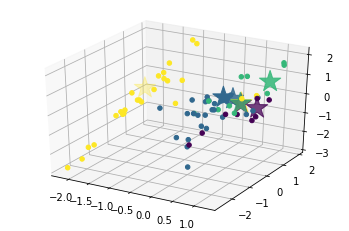

In [17]:
# 3D visualizing the predictions
z, x, y = X_test[:, 2], X_test[:, 0], X_test[:, 1]
Z, X, Y = protos[:, 2], protos[:, 0], protos[:, 1]
fig = plt.figure()
ax = fig.add_subplot(111, projection= '3d')
ax.scatter(x,y,z, c=predictions, alpha= 1)
ax.scatter(X,Y,Z, c=protos_class, s=500, marker= '*')
plt.show()
